<a href="https://colab.research.google.com/github/TerjeNorderhaug/patient1/blob/master/Undiagnosed1_Workbench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Undiagnosed-1 Workbench by Patient1



In [1]:
!pip install tf-nightly-gpu-2.0-preview   # 2.0.0-alpha0 incompatible with Clairvoyante

import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 346.5MB 64kB/s 
     |████████████████████████████████| 3.1MB 24.5MB/s 
     |████████████████████████████████| 61kB 20.7MB/s 
     |████████████████████████████████| 430kB 27.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11
2.0.0-dev20190506


## Install Nucleus

[Nucleus](https://github.com/google/nucleus) is a library of Python code for reading, writing, and filtering common genomics file formats for conversion to TensorFlow examples. This installation works with TF2.



In [2]:
!pip install -q google-nucleus==0.2.2  # Other versions refuses TF2

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random

import numpy as np
import tensorflow as tf

from nucleus.io import fasta
from nucleus.io import sam
from nucleus.io import vcf
from nucleus.io.genomics_writer import TFRecordWriter
from nucleus.protos import reads_pb2
from nucleus.util import cigar
from nucleus.util import ranges
from nucleus.util import utils

     |████████████████████████████████| 7.6MB 2.7MB/s 


## Clairvoyante TF2 Update

[Clairvoyante](https://github.com/aquaskyline/Clairvoyante) is a Tensorflow based variant caller, a multi-task five-layer convolutional neural network model for predicting variant type, zygosity, alternative allele and Indel length. **We have upgraded it for Tensorflow 2.**

In [3]:
import os
! rm -r Clairvoyante_download
! git clone --depth=1 https://github.com/aquaskyline/Clairvoyante.git Clairvoyante_download
! # https://www.tensorflow.org/alpha/guide/upgrade
print(os.listdir('./Clairvoyante_download'))


rm: cannot remove 'Clairvoyante_download': No such file or directory
Cloning into 'Clairvoyante_download'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 49 (delta 13), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (49/49), done.
['port23.py', 'clairvoyante.py', '.git', 'README.md', 'dataPrepScripts', 'Dockerfile', 'clairvoyante', '.gitignore', 'requirements.txt', '.gitattributes', 'requirements_pypy.txt', 'LICENSE.md', 'jupyter_nb']


In [4]:
!rm -r ./Clairvoyante
!rm -r ./Clairvoyante_tmp
!cp -r ./Clairvoyante_download ./Clairvoyante_tmp
# tf_upgrade_v2 script assumes tensorflow is imported as 'tf' for pattern matching
!find ./Clairvoyante_tmp -type f -name "*.py" -print0 | xargs -0 sed -i '' -e 's/tensorflow\./tf\./g'
!tf_upgrade_v2 --intree ./Clairvoyante_tmp --outtree ./Clairvoyante


rm: cannot remove './Clairvoyante': No such file or directory
rm: cannot remove './Clairvoyante_tmp': No such file or directory
sed: can't read : No such file or directory
INFO line 29:23: Renamed 'tf.Session' to 'tf.compat.v1.Session'
INFO line 33:18: Renamed 'tf.placeholder' to 'tf.compat.v1.placeholder'
INFO line 36:18: Renamed 'tf.placeholder' to 'tf.compat.v1.placeholder'
INFO line 39:29: Renamed 'tf.placeholder' to 'tf.compat.v1.placeholder'
INFO line 42:22: Renamed 'tf.placeholder' to 'tf.compat.v1.placeholder'
INFO line 45:31: Renamed 'tf.placeholder' to 'tf.compat.v1.placeholder'
INFO line 48:31: Renamed 'tf.placeholder' to 'tf.compat.v1.placeholder'
INFO line 51:39: Renamed 'tf.placeholder' to 'tf.compat.v1.placeholder'
INFO line 54:20: Renamed 'tf.layers.conv2d' to 'tf.compat.v1.layers.conv2d'
INFO line 57:58: Changing tf.contrib.layers.variance_scaling_initializer to a tf.compat.v1.keras.initializers.VarianceScaling and converting arguments.

INFO line 63:20: Renamed 'tf.la

In [5]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.python.framework
import tensorflow.python.ops
from tensorflow.python.layers import utils
from tensorflow.keras.initializers import VarianceScaling

!find ./Clairvoyante -type f -name "selu.py" -print0 | xargs -0 sed -i '' -e 's/from tf.contrib import layers/from tensorflow.keras.initializers import VarianceScaling/g'
!find ./Clairvoyante -type f -name "selu.py" -print0 | xargs -0 sed -i '' -e "s/layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')/VarianceScaling\(scale=1.0, mode='fan_in'\)/g"

!find ./Clairvoyante -type f -name "clairvoyante_v3.py" -print0 | xargs -0 sed -i '' -e "s/import selu/import selu\nfrom tensorflow.keras.initializers import VarianceScaling/g"
!find ./Clairvoyante -type f -name "clairvoyante_v3.py" -print0 | xargs -0 sed -i '' -e "s/tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False)/VarianceScaling(scale=1.0, mode='fan_in', distribution='truncated_normal')/g"

# Missed by the upgrade script:
#!find ./Clairvoyante -type f -name "*.py" -print0 | xargs -0 sed -i '' -e 's/from tf.contrib import layers/from tensorflow.keras import layers/g'
!find ./Clairvoyante -type f -name "*.py" -print0 | xargs -0 sed -i '' -e 's/tf.python.framework/tensorflow.python.framework/g'
!find ./Clairvoyante -type f -name "*.py" -print0 | xargs -0 sed -i '' -e 's/tf.python.ops/tensorflow.python.ops/g'
!find ./Clairvoyante -type f -name "*.py" -print0 | xargs -0 sed -i '' -e 's/tf.contrib.layers.python.layers/tensorflow.python.layers/g'
!find ./Clairvoyante -type f -name "*.py" -print0 | xargs -0 sed -i '' -e 's/tf.contrib.layers.python.layers/tensorflow.python.layers/g'


print(os.listdir('./Clairvoyante'))
!cat "./Clairvoyante/clairvoyante/selu.py"

sed: can't read : No such file or directory
sed: can't read : No such file or directory
sed: can't read : No such file or directory
sed: can't read : No such file or directory
sed: can't read : No such file or directory
sed: can't read : No such file or directory
sed: can't read : No such file or directory
sed: can't read : No such file or directory
['port23.py', 'clairvoyante.py', '.git', 'README.md', 'dataPrepScripts', 'Dockerfile', 'clairvoyante', '.gitignore', 'requirements.txt', '.gitattributes', 'requirements_pypy.txt', 'LICENSE.md', 'jupyter_nb']
'''
Tensorflow Implementation of the Scaled ELU function and Dropout
'''

from __future__ import absolute_import, division, print_function
import numbers
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import ra

In [6]:
# !pip install --upgrade setuptools pip
!pip install blosc
!pip install intervaltree==2.1.0
!pip install numpy

     |████████████████████████████████| 778kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/3b/e0/b9/99a77fb1821f0df30e52b9ce470c74efa2ca359ff8c21f8e17
Successfully built blosc


In [7]:
import os
import sys
print(os.listdir('.'))
print(os.listdir('./Clairvoyante'))
print(os.listdir('./Clairvoyante/clairvoyante'))
sys.path.append('./Clairvoyante')
# sys.path.append('./Clairvoyante/clairvoyante')

['.config', 'report.txt', 'Clairvoyante_tmp', 'Clairvoyante', 'Clairvoyante_download', 'sample_data']
['port23.py', 'clairvoyante.py', '.git', 'README.md', 'dataPrepScripts', 'Dockerfile', 'clairvoyante', '.gitignore', 'requirements.txt', '.gitattributes', 'requirements_pypy.txt', 'LICENSE.md', 'jupyter_nb']
['evaluate.py', 'tensor2Bin.py', 'clairvoyante_v3_slim.py', 'callVar.py', 'selu.py', 'clairvoyante_v2.py', 'clairvoyante_v2_slim.py', 'calTrainDevDiff.py', 'callVarBamParallel.py', '__init__.py', 'clairvoyante_v3.py', 'utils_v2.py', 'demoRun.py', 'trainNonstop.py', 'evaluateListOfModels.py', 'trainWithoutValidationNonstop.py', 'getEmbedding.py', 'callVarBam.py', 'train.py', 'getTensorAndLayerPNG.py', 'param.py']


### Accelerate with PyPy

In [8]:
!apt-get -y install pypy samtools wget pypy-dev parallel
!wget https://bootstrap.pypa.io/get-pip.py
!sudo pypy get-pip.py 
!sudo pypy -m pip install intervaltree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cron cwltool libc-ares2 libhts2 libhttp-parser2.7.1 libjs-bootstrap nodejs
  nodejs-doc pypy-lib python-asn1crypto python-avro python-cachecontrol
  python-certifi python-cffi-backend python-chardet python-cryptography
  python-enum34 python-html5lib python-idna python-ipaddress python-isodate
  python-lockfile python-mistune python-openssl python-pkg-resources
  python-pyparsing python-rdflib python-rdflib-jsonld python-requests
  python-ruamel.yaml python-schema-salad python-shellescape python-six
  python-sparqlwrapper python-typing python-urllib3 python-webencodings
  sysstat
Suggested packages:
  anacron logrotate checksecurity exim4 | postfix |

# Variant Calling

The data for Undiagnosed-1 is only available for the participants and could not be included in this public notebook. Substitute with the data links below.

In [9]:
!wget 'http://www.bio8.cs.hku.hk/training.tar'
!tar -xf training.tar

!cd Clairvoyante
!curl http://www.bio8.cs.hku.hk/trainedModels.tbz | tar -jxf -
  
print(os.listdir('./trainedModels/fullv3-illumina-novoalign-hg001+hg002-hg38/'))
trained_model = "../trainedModels/fullv3-illumina-novoalign-hg001+hg002-hg38/learningRate1e-3.epoch500"
tensor_file = "tensor_can_chr21"
variant_calls_file = "tensor_can_chr21.vcf"


--2019-05-07 04:45:48--  http://www.bio8.cs.hku.hk/training.tar
Resolving www.bio8.cs.hku.hk (www.bio8.cs.hku.hk)... 147.8.179.16
Connecting to www.bio8.cs.hku.hk (www.bio8.cs.hku.hk)|147.8.179.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 380336971 (363M) [application/x-tar]
Saving to: ‘training.tar’

training.tar        100%[===================>] 362.72M  4.78MB/s    in 76s     

2019-05-07 04:47:04 (4.80 MB/s) - ‘training.tar’ saved [380336971/380336971]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  259M  100  259M    0     0  4416k      0  0:01:00  0:01:00 --:--:-- 5123k
['learningRate1e-3.epoch500.meta', 'learningRate1e-3.epoch500.data-00000-of-00001', 'learningRate1e-3.epoch500.index']


In [10]:
import os
import sys
import clairvoyante.utils_v2
import clairvoyante.clairvoyante_v3
import clairvoyante.callVar
from mock import patch


def call_variants (trained_model, tensor_file, variant_calls_file):
  args = \
  ["callVar.py",
   "--chkpnt_fn", trained_model, \
   "--tensor_fn", tensor_file, \
   "--call_fn", variant_calls_file]

  try:
    os.chdir("./training")
    with patch.object(sys, 'argv', args):
      clairvoyante.callVar.main()
  finally:
    os.chdir("..")
 

call_variants (trained_model, tensor_file, variant_calls_file)

W0507 04:48:14.256031 140401733343104 deprecation.py:323] From ./Clairvoyante/clairvoyante/clairvoyante_v3.py:61: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0507 04:48:14.814357 140401733343104 ag_logging.py:145] Entity <function selu at 0x7fb16fb08ed8> could not be transformed and will be executed as-is. Some features (e.g. tensor-dependent conditionals and loops) may not work as expected. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Unexpected error transforming <function selu at 0x7fb16fb08ed8>. If you believe this is due to a bug, please set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output when filing the bug report. Caused by: Unable to locate the source code of <function selu at 0x7fb16fb08ed8>. Note that fu

W0507 04:48:15.037087 140401733343104 ag_logging.py:145] Entity <function selu at 0x7fb16fb08ed8> could not be transformed and will be executed as-is. Some features (e.g. tensor-dependent conditionals and loops) may not work as expected. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Unexpected error transforming <function selu at 0x7fb16fb08ed8>. If you believe this is due to a bug, please set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output when filing the bug report. Caused by: Unable to locate the source code of <function selu at 0x7fb16fb08ed8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original er

W0507 04:48:15.413589 140401733343104 ag_logging.py:145] Entity <function selu at 0x7fb16fb08ed8> could not be transformed and will be executed as-is. Some features (e.g. tensor-dependent conditionals and loops) may not work as expected. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Unexpected error transforming <function selu at 0x7fb16fb08ed8>. If you believe this is due to a bug, please set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output when filing the bug report. Caused by: Unable to locate the source code of <function selu at 0x7fb16fb08ed8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original er

W0507 04:48:15.641139 140401733343104 ag_logging.py:145] Entity <function selu at 0x7fb16fb08ed8> could not be transformed and will be executed as-is. Some features (e.g. tensor-dependent conditionals and loops) may not work as expected. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Unexpected error transforming <function selu at 0x7fb16fb08ed8>. If you believe this is due to a bug, please set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output when filing the bug report. Caused by: Unable to locate the source code of <function selu at 0x7fb16fb08ed8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original er

W0507 04:48:17.164077 140401733343104 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
Processed 1000 tensors
Processed 2000 tensors
Processed 3000 tensors
Processed 4000 tensors
Processed 5000 tensors
Processed 6000 tensors
Processed 7000 tensors
Processed 8000 tensors
Processed 9000 tensors
Processed 10000 tensors
Processed 11000 tensors
Processed 12000 tensors
Processed 13000 tensors
Processed 14000 tensors
Processed 15000 tensors
Processed 16000 tensors
Processed 17000 tensors
Processed 18000 tensors
Processed 19000 tensors
Processed 20000 tensors
Processed 21000 tensors
Processed 22000 tensors
Processed 23000 tensors
Processed 24000 tensors
Processed 25000 tensors
Processed 26000 tensors
Processed 27000 tensors
P

### Verify variants



In [11]:
with open('./training/tensor_can_chr21.vcf', mode='r') as vcf:
    print(vcf.read())

##fileformat=VCFv4.1
##FILTER=<ID=PASS,Description="All filters passed">
##FILTER=<ID=LowQual,Description="Confidence in this variant being real is below calling threshold.">
##ALT=<ID=DEL,Description="Deletion">
##ALT=<ID=INS,Description="Insertion of novel sequence">
##INFO=<ID=SVTYPE,Number=1,Type=String,Description="Type of structural variant">
##INFO=<ID=LENGUESS,Number=.,Type=Integer,Description="Best guess of the indel length">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">
##FORMAT=<ID=AF,Number=1,Type=Float,Description="Estimated allele frequency in the range (0,1)">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	SAMPLE
chr21	10368055	.	A	G	397	.	.	GT:GQ:DP:AF	0/1:397:131:0.6336
chr21	10370153	.	C	T	65	.	.	GT:GQ:DP:AF	0/1:65:6:0.1667
chr21	10374503	.	AAAGAG	A	149	.	LENGUESS=5	GT:GQ:DP:AF	0/1:149:130:0.0000
chr21	10374688	.	G	A	231	.

## View Variants

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import clairvoyante.utils_v2 as utils
from clairvoyante.getTensorAndLayerPNG import PlotTensor

# Load the trained dataset
total, XArrayCompressed, YArrayCompressed, posArrayCompressed = \
  utils.GetTrainingArray("./training/tensor_can_chr21",
                         "./training/var_chr21",
                         "./training/bed",
                         shuffle = False)

def show_variant_tensors (i = 0):
  XArray, _, _ = utils.DecompressArray(XArrayCompressed, i, 1, total)
  fig = plt.figure(figsize=(15, 8));
  fig.suptitle("Variant {0}".format(i), fontsize=16)
  def tensor_subplot(ix, vmin=0, cmap=plt.cm.hot):
    plt.subplot(4,1,ix); 
    plt.xticks(np.arange(0, 33, 1)); 
    plt.yticks(np.arange(0, 4, 1), ['A','C','G','T'])
    plt.imshow(XArray[0,:,:,ix-1].transpose(), vmin=vmin, vmax=50, interpolation="nearest", cmap=cmap); 
    plt.colorbar()
  tensor_subplot(1);
  tensor_subplot(2, vmin=-50, cmap=plt.cm.bwr)
  tensor_subplot(3, vmin=-50, cmap=plt.cm.bwr)
  tensor_subplot(4, vmin=-50, cmap=plt.cm.bwr)
  plt.show()

print("Total:", total)

./Clairvoyante/clairvoyante/getTensorAndLayerPNG.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlet

Total: 132967


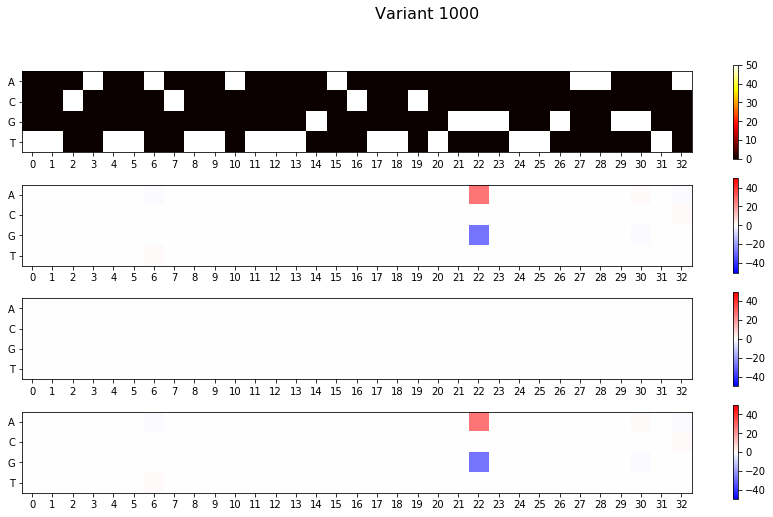

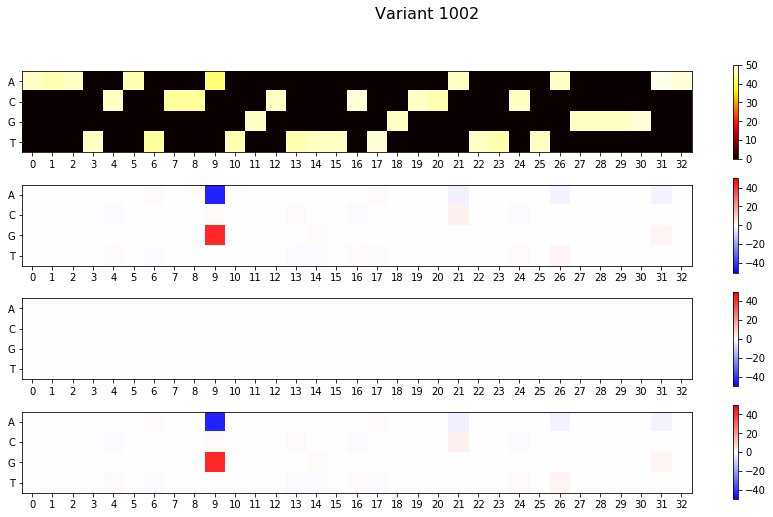

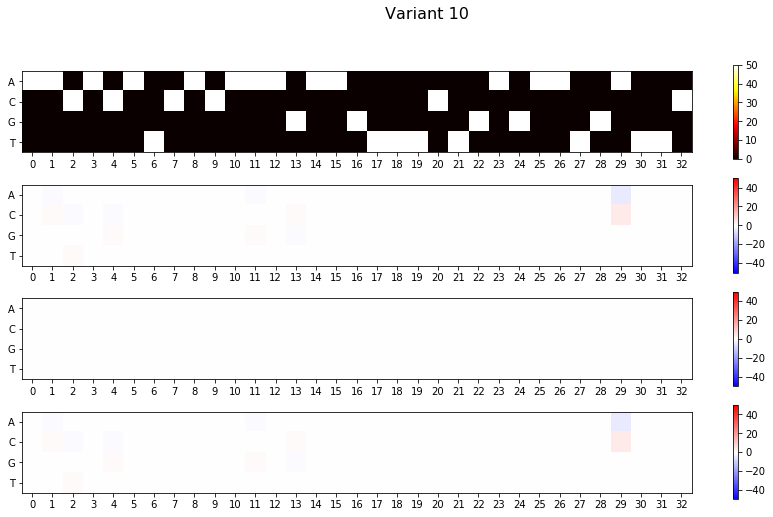

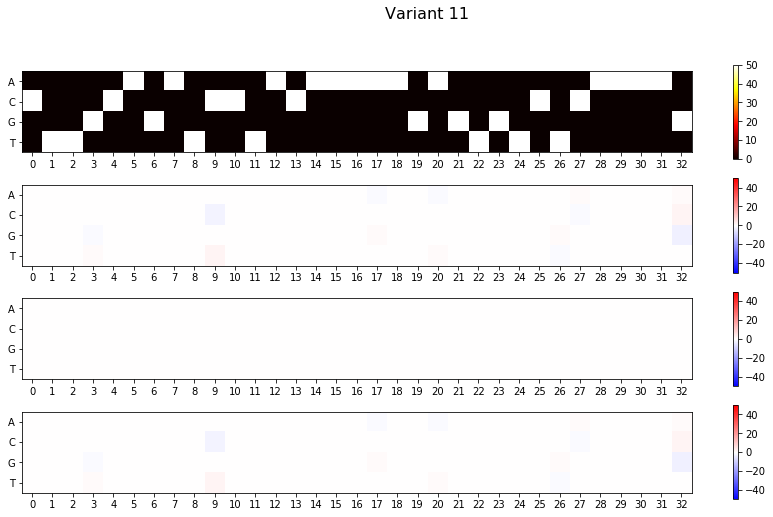

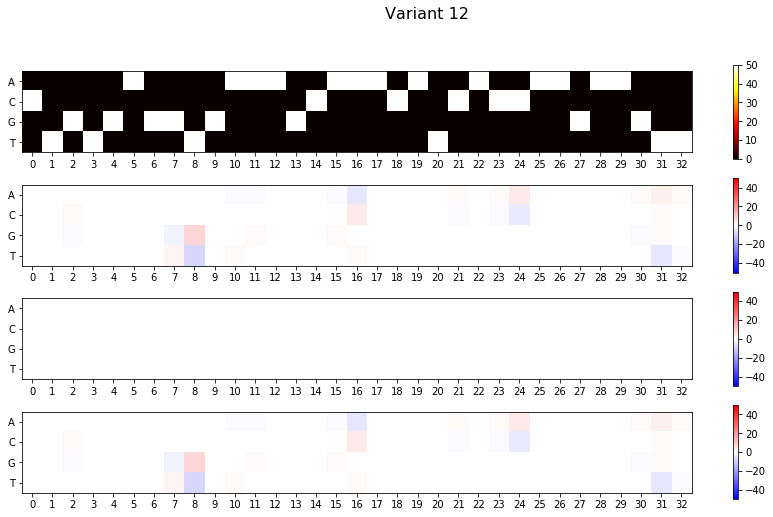

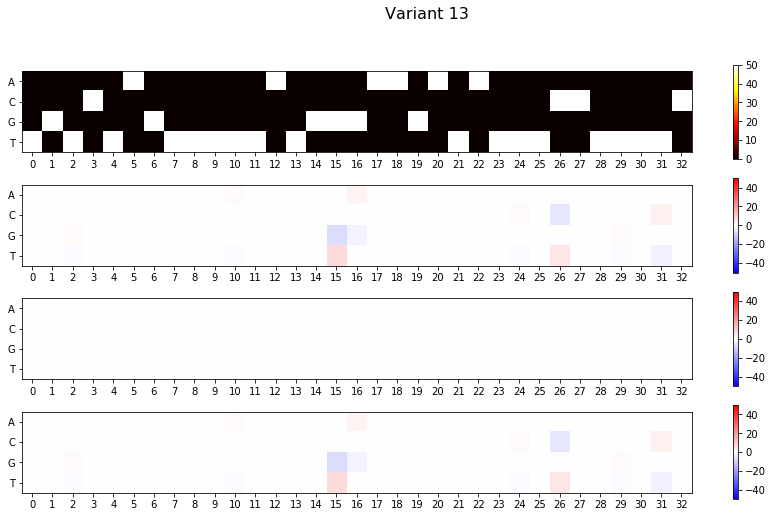

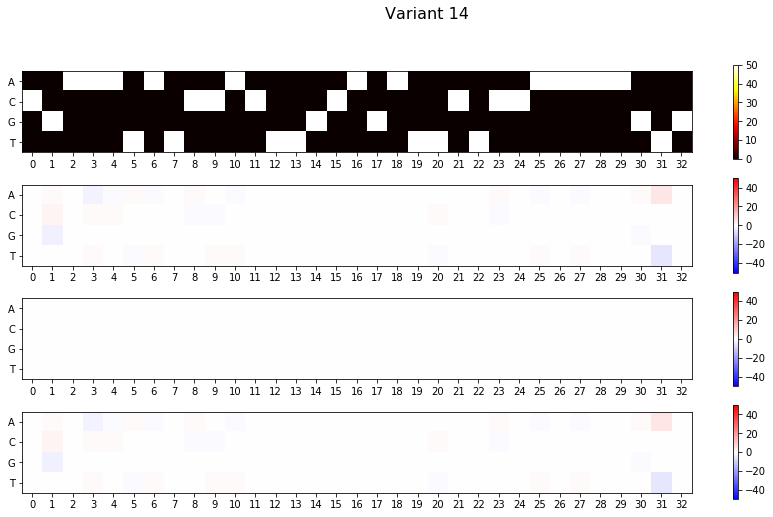

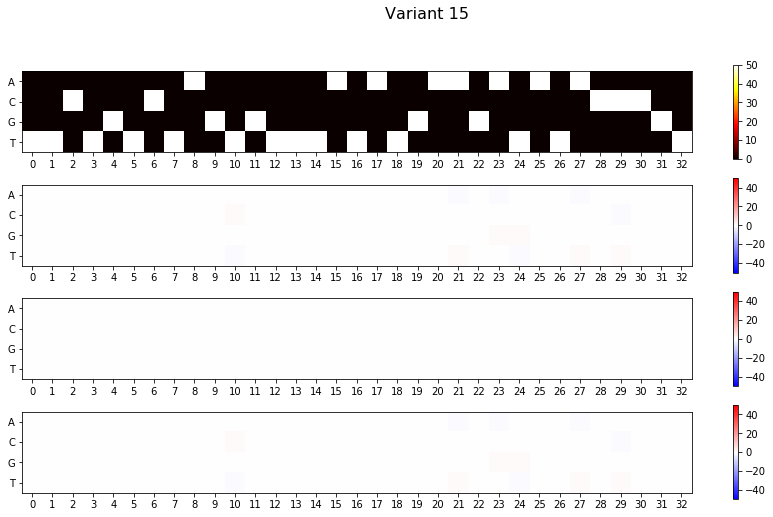

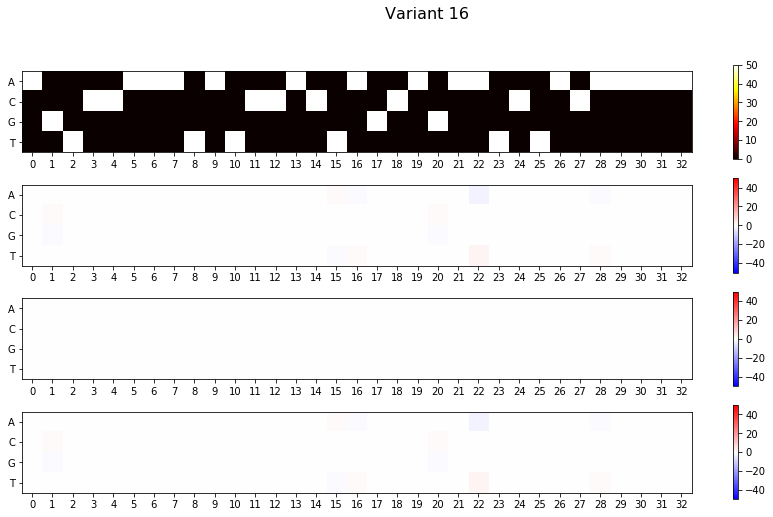

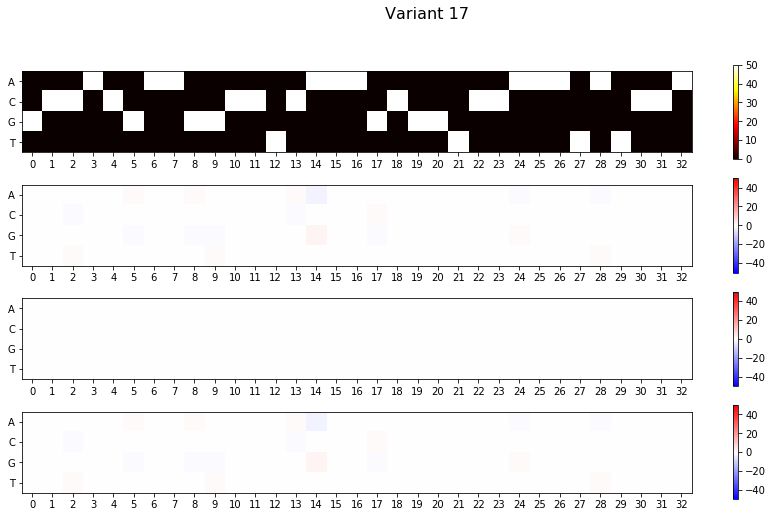

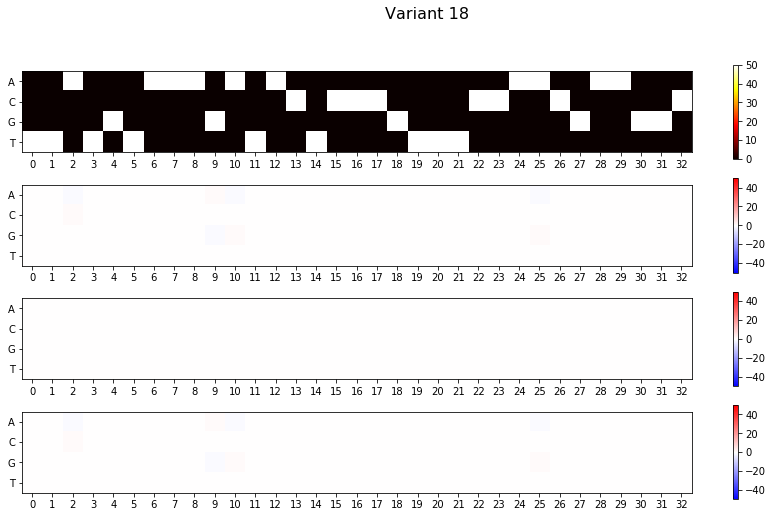

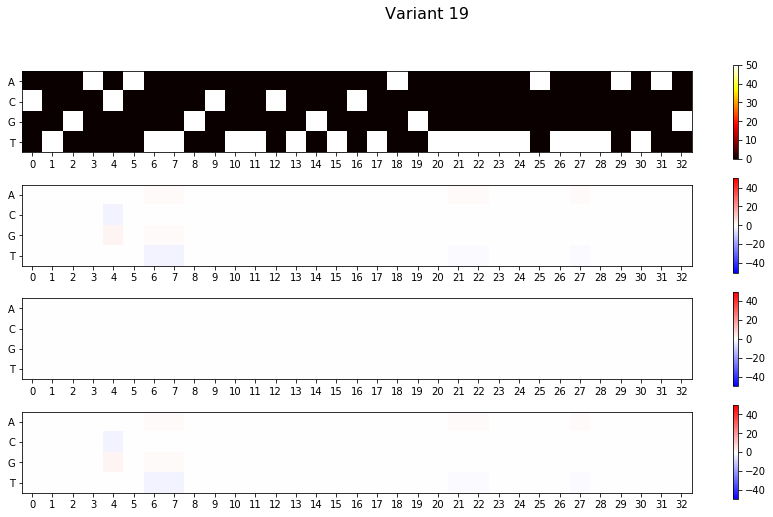

In [13]:
show_variant_tensors(1000)
show_variant_tensors(1002)

for i in range(10,20):
  show_variant_tensors(i)

## Inspect Variants With Nucleus

In [14]:
from nucleus.io import vcf

with vcf.VcfReader('./training/tensor_can_chr21.vcf') as reader:
  print('Sample names in VCF: ', ' '.join(reader.header.sample_names))
  with vcf.VcfWriter('/tmp/filtered.tfrecord', header=reader.header) as writer:
    for variant in reader:
      print(variant)
      if variant.quality > 3.01:
        writer.write(variant)

Sample names in VCF:  SAMPLE
reference_bases: "A"
alternate_bases: "G"
quality: 397.0
info {
  key: "LENGUESS"
  value {
  }
}
info {
  key: "SVTYPE"
  value {
  }
}
calls {
  info {
    key: "AF"
    value {
      values {
        number_value: 0.633599996567
      }
    }
  }
  info {
    key: "DP"
    value {
      values {
        int_value: 131
      }
    }
  }
  info {
    key: "GQ"
    value {
      values {
        int_value: 397
      }
    }
  }
  genotype: 0
  genotype: 1
  call_set_name: "SAMPLE"
}
end: 10368055
reference_name: "chr21"
start: 10368054

reference_bases: "C"
alternate_bases: "T"
quality: 65.0
info {
  key: "LENGUESS"
  value {
  }
}
info {
  key: "SVTYPE"
  value {
  }
}
calls {
  info {
    key: "AF"
    value {
      values {
        number_value: 0.166700005531
      }
    }
  }
  info {
    key: "DP"
    value {
      values {
        int_value: 6
      }
    }
  }
  info {
    key: "GQ"
    value {
      values {
        int_value: 65
      }
    }
  }


## Variant Calling On Generated Data

Grab a coffee while you wait...

In [15]:
!wget 'http://www.bio8.cs.hku.hk/testingData.tar'
!tar -xf testingData.tar

print(os.listdir('.'))

!cd dataPrepScripts
!sh PrepDataBeforeDemo.sh

--2019-05-07 04:50:11--  http://www.bio8.cs.hku.hk/testingData.tar
Resolving www.bio8.cs.hku.hk (www.bio8.cs.hku.hk)... 147.8.179.16
Connecting to www.bio8.cs.hku.hk (www.bio8.cs.hku.hk)|147.8.179.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2406322764 (2.2G) [application/x-tar]
Saving to: ‘testingData.tar’

testingData.tar     100%[===================>]   2.24G  5.00MB/s    in 11m 37s 

2019-05-07 05:01:49 (3.29 MB/s) - ‘testingData.tar’ saved [2406322764/2406322764]

['.config', 'testingData.tar', 'training.tar', 'training', 'testingData', 'report.txt', 'Clairvoyante_tmp', 'get-pip.py', 'Clairvoyante', 'Clairvoyante_download', 'trainedModels', 'sample_data']
/bin/bash: line 0: cd: dataPrepScripts: No such file or directory
sh: 0: Can't open PrepDataBeforeDemo.sh


In [16]:
import sys
import clairvoyante.callVarBam
from mock import patch

print(os.getcwd())

print(os.listdir('.'))
print("Trained Models:", os.listdir('./trainedModels/'))
print(os.listdir('./trainedModels/fullv3-illumina-novoalign-hg001+hg002-hg38/'))
print("TestingData:", os.listdir('./testingData/chr21'))
print("Training:", os.listdir('./training/'))

def call_var_bam(outfile):
  # Hack to override sysargs.
  args = \
  ["callVarBam.py", 
   "--chkpnt_fn", "../trainedModels/fullv3-illumina-novoalign-hg001+hg002-hg38/learningRate1e-3.epoch500", \
   "--bam_fn", "../testingData/chr21/chr21.bam", \
   "--ref_fn", "../testingData/chr21/chr21.fa", \
   "--bed_fn", "../testingData/chr21/chr21.bed", \
   "--call_fn", outfile,  \
   "--ctgName", "chr21"]
  try:
    os.chdir("./training")
    with patch.object(sys, 'argv', args):
      clairvoyante.callVarBam.main()
  finally:
    os.chdir("..")
  

call_var_bam("chr21_calls.vcf")

/content
['.config', 'testingData.tar', 'training.tar', 'training', 'testingData', 'report.txt', 'Clairvoyante_tmp', 'get-pip.py', 'Clairvoyante', 'Clairvoyante_download', 'trainedModels', 'sample_data']
Trained Models: ['fullv3-pacbio-ngmlr-hg001-hg19', 'fullv3-ont-ngmlr-hg001-hg19', 'fullv3-illumina-novoalign-hg001+hg002-hg38', 'fullv3-illumina-novoalign-hg002-hg38', 'fullv3-pacbio-ngmlr-hg001+hg002-hg19', 'fullv3-pacbio-ngmlr-hg002-hg19', 'fullv3-pacbio-ngmlr-hg001+hg002+hg003+hg004-hg19', 'fullv3-illumina-novoalign-hg001-hg38']
['learningRate1e-3.epoch500.meta', 'learningRate1e-3.epoch500.data-00000-of-00001', 'learningRate1e-3.epoch500.index']
TestingData: ['chr21.fa.fai', 'chr21.fa', 'chr21.vcf', 'chr21.bam', 'chr21.bam.bai', 'chr21.bed']
Training: ['tensor_can_chr21', 'tensor.bin', 'var_chr21', 'bed', 'var_chr22', 'tensor_can_mul', 'tensor_can_chr22', 'can_chr21_sampled', 'can_chr22_sampled', 'var_mul', 'tensor_can_chr21.vcf', 'can_chr21', 'can_chr22']


SystemExit: ignored

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
